<a href="https://colab.research.google.com/github/KevinHern/SemProProject1/blob/master/Dermatology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto: Enfermedades Dermatológicas

## Miembros
Edy Adolfo Cocon Marroquin - 

Javier Antonio Ferrer Morales -

Kevin José Hernández Marroquín - 17001095

## Introducción
En la actualidad, para la detección de enfermedades de piel aún se emplean métodos primitivos, como por ejemplo tomar una foto e ir comparando si los síntomas que presenta se asemeja con alguna imagen de algun libro, etc.

Hasta el momento, se ha logrado combinar la ciencia para la detección de dichas enfermedades. Sin embargo, el reto de estas enfermedades de la piel es predecir con certeza qué enfermedad es exactamente.

El reto de los dermatólogos es identificar con exactitud la enfermedad dermatológica que presenta el paciente, ya que la mayoría de los síntomas son muy similares entre varias enfermedades, entonces esto complica mucho a la hora de decidir el veredicto final.

Con este proyecto, atacaremos este reto de clasificar las enfermedades de la piel usando la tecnología y la rama de la Inteligencia Artificial: Machine learning.

## Objetivos
Los objetivos de este proyecto son los siguientes:

*   Encontrar la mejor arquitectura para la clasificación de enfermedades.
*   Demostrar qué tiene más relevancia: únicamente los datos clínicos, únicamente los datos histopatológicos, la combinación de ambos o si la selección de los más importantes entre los datos clínicos e histopatológicos a la hora de detectar qué enfermedad de piel tiene un paciente.



# Librerías

In [0]:
%tensorflow_version 2.x

import tensorflow as tf
from tensorflow.math import confusion_matrix
import tensorflow_hub as hub

from tensorflow.keras import Sequential
from tensorflow.keras.utils import get_file
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import os
import shutil
import numpy as np
import PIL.Image as Image
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math

from sklearn import preprocessing

seed=1234
np.random.seed(seed)
tf.random.set_seed(seed)

# Dataset

## Extracting

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/KevinHern/SemProProject1/master/dermatology.csv')

## Getting to know the Dataset

In [146]:
df.head()

,2,2.1,0,3,0.1,0.2,0.3,0.4,1,0.5,0.6,0.7,0.8,0.9,0.10,3.1,2.2,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.20,3.2,0.21,0.22,0.23,1.1,0.24,55,2.3
0,3,3,3,2,1,0,0,0,1,1,1,0,0,1,0,1,2,0,2,2,2,2,2,1,0,0,0,0,0,0,0,1,0,8,1
1,2,1,2,3,1,3,0,3,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,2,0,2,3,2,0,0,2,3,26,3
2,2,2,2,0,0,0,0,0,3,2,0,0,0,3,0,0,2,0,3,2,2,2,2,0,0,3,0,0,0,0,0,3,0,40,1
3,2,3,2,2,2,2,0,2,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,2,2,3,2,3,0,0,2,3,45,3
4,2,3,2,0,0,0,0,0,0,0,0,0,2,1,0,2,2,0,2,0,0,0,1,0,0,0,0,2,0,0,0,1,0,41,2


In [0]:
df.columns = ['erythema', 'scaling', 'definite borders', 'itching', 'koebner phenomenon', 
              'polygonal papules', 'follicular papules', 'oral mucosal involvement', 
              'knee and elbow involvement', 'scalp involvement', 'history', 
               'melanin incontinence', 'eosinophils in the infiltrate', 'PNL infiltrate', 
              'fibrosis of the papillary dermis', 'exocytosis', 'acanthosis', 'hyperkeratosis', 
              'parakeratosis', 'clubbing of the rete ridges', 'elongation of the rete ridges', 
              'thinning of the suprapapillary epidermis', 'spongiform pustule', 'munro microabcess',
              'focal hypergranulosis', 'disappearance of the granular layer', 
              'vacuolisation and damage of basal layer', 'spongiosis', 
              'saw-tooth appearance of retes', 'follicular horn plug', 
              'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate', 'band-like infiltrate','Age', 'Classcode']
df['Classcode'] = df['Classcode'] - 1

In [148]:
df

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,history,melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Classcode
0,3,3,3,2,1,0,0,0,1,1,1,0,0,1,0,1,2,0,2,2,2,2,2,1,0,0,0,0,0,0,0,1,0,8,0
1,2,1,2,3,1,3,0,3,0,0,0,1,0,0,0,1,2,0,2,0,0,0,0,0,2,0,2,3,2,0,0,2,3,26,2
2,2,2,2,0,0,0,0,0,3,2,0,0,0,3,0,0,2,0,3,2,2,2,2,0,0,3,0,0,0,0,0,3,0,40,0
3,2,3,2,2,2,2,0,2,0,0,0,1,0,0,0,1,2,0,0,0,0,0,0,0,2,2,3,2,3,0,0,2,3,45,2
4,2,3,2,0,0,0,0,0,0,0,0,0,2,1,0,2,2,0,2,0,0,0,1,0,0,0,0,2,0,0,0,1,0,41,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2,1,1,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,25,3
361,3,2,1,0,1,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,1,0,1,0,0,0,2,0,36,3
362,3,2,2,2,3,2,0,2,0,0,0,2,2,0,0,3,3,0,0,0,0,0,0,0,3,0,3,0,3,0,0,2,3,28,2
363,2,1,3,1,2,3,0,2,0,0,0,2,0,0,0,3,2,0,0,0,0,0,0,0,3,0,2,0,1,0,0,2,3,50,2


## Cleaning Dataset

In [149]:
temp = df[df['Age'] != '?']
temp = temp.astype(int)
meanAge = math.floor(temp['Age'].mean())
meanAge

36

In [150]:
df = df.replace('?', meanAge)
df[df['Age'] == '?']

,erythema,scaling,definite borders,itching,koebner phenomenon,polygonal papules,follicular papules,oral mucosal involvement,knee and elbow involvement,scalp involvement,history,melanin incontinence,eosinophils in the infiltrate,PNL infiltrate,fibrosis of the papillary dermis,exocytosis,acanthosis,hyperkeratosis,parakeratosis,clubbing of the rete ridges,elongation of the rete ridges,thinning of the suprapapillary epidermis,spongiform pustule,munro microabcess,focal hypergranulosis,disappearance of the granular layer,vacuolisation and damage of basal layer,spongiosis,saw-tooth appearance of retes,follicular horn plug,perifollicular parakeratosis,inflammatory monoluclear inflitrate,band-like infiltrate,Age,Classcode


In [151]:
for i in df.columns:
  df[i] = df[i].astype(int)
df.dtypes

erythema                                    int64
scaling                                     int64
definite borders                            int64
itching                                     int64
koebner phenomenon                          int64
polygonal papules                           int64
follicular papules                          int64
oral mucosal involvement                    int64
knee and elbow involvement                  int64
scalp involvement                           int64
history                                     int64
melanin incontinence                        int64
eosinophils in the infiltrate               int64
PNL infiltrate                              int64
fibrosis of the papillary dermis            int64
exocytosis                                  int64
acanthosis                                  int64
hyperkeratosis                              int64
parakeratosis                               int64
clubbing of the rete ridges                 int64


## Correlation

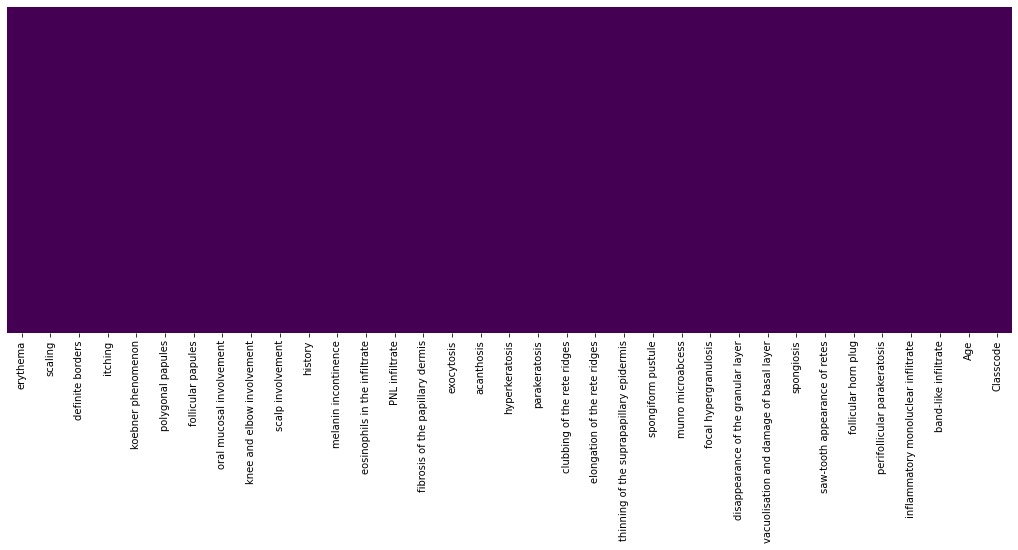

In [152]:
plt.figure(figsize=(18,6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis', xticklabels=True)

In [0]:
corr = df.corr()

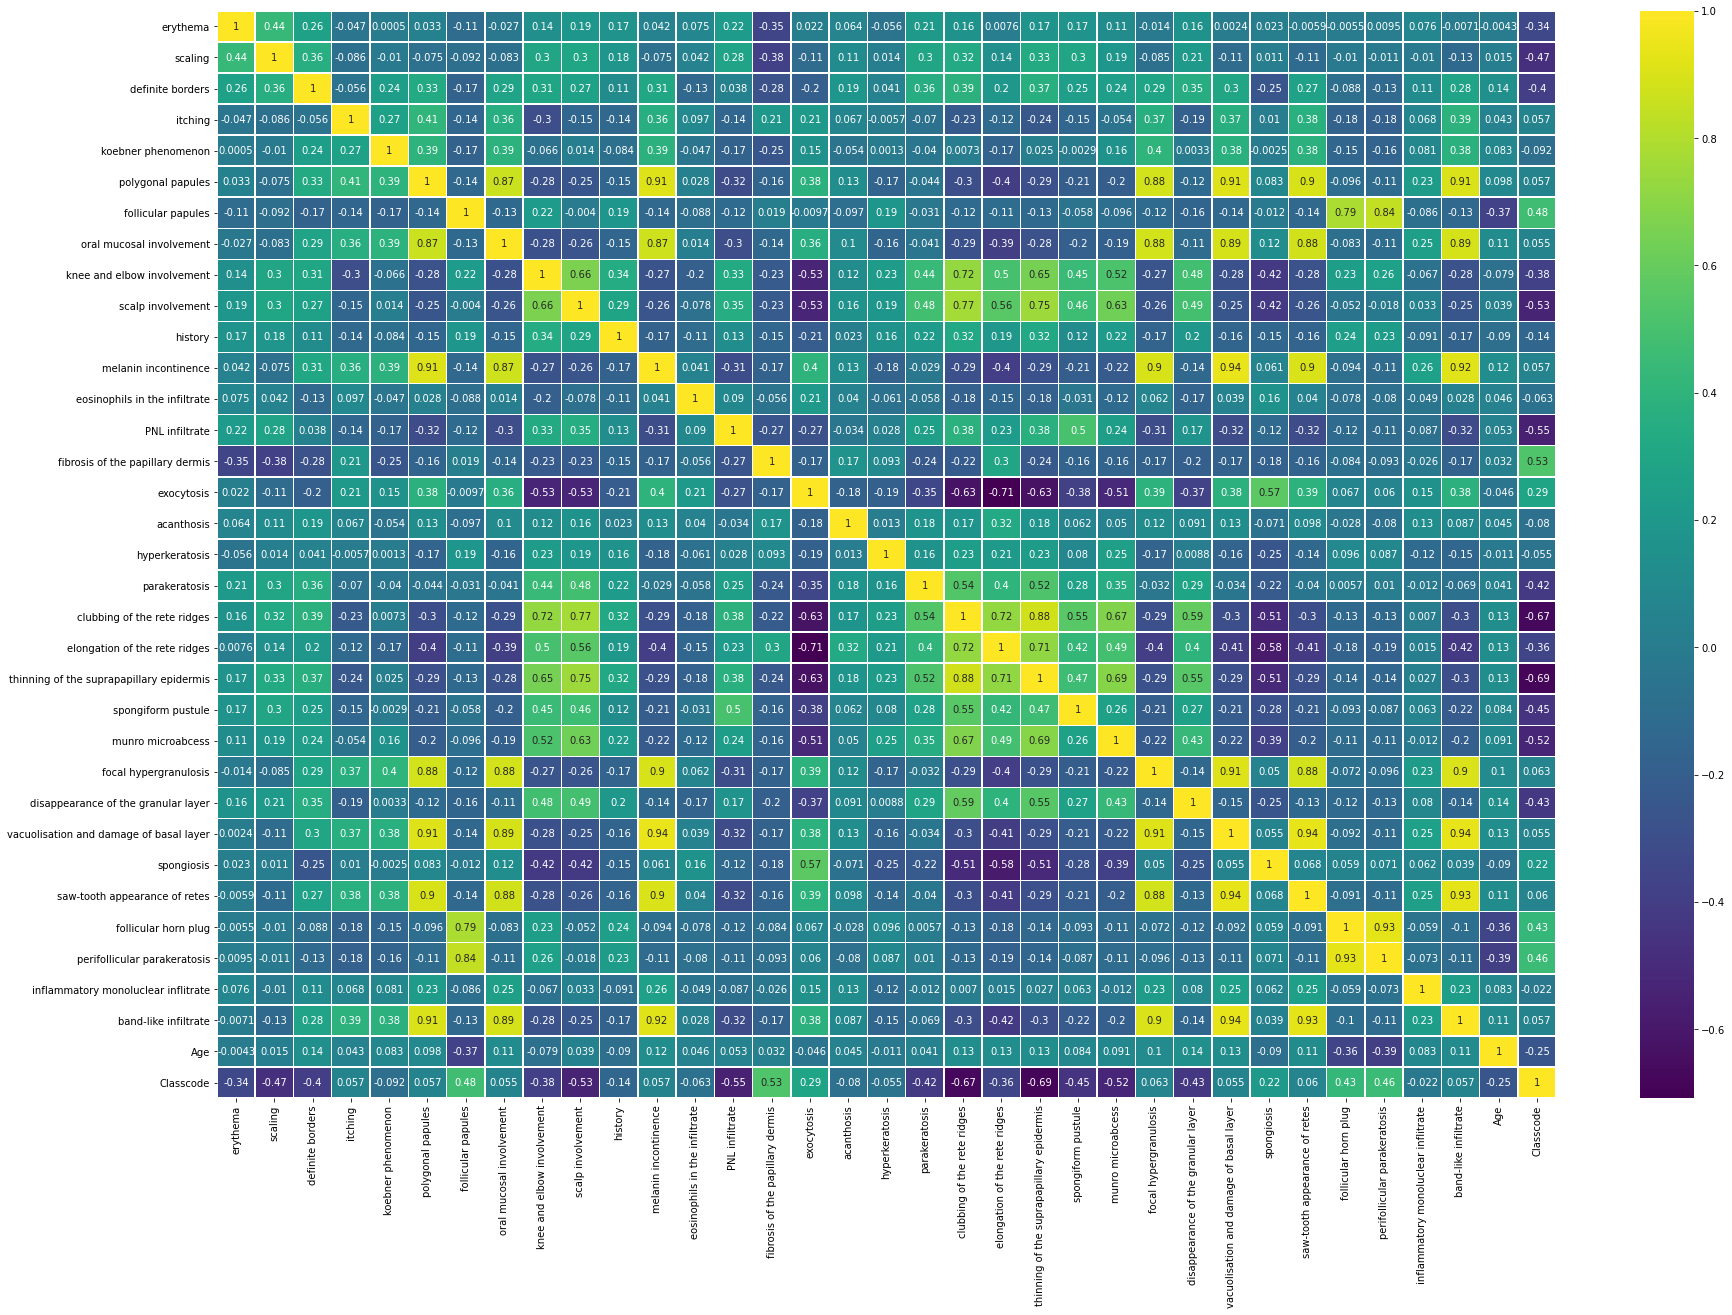

In [214]:
plt.figure(figsize=(30,20))
sns.heatmap(corr, linewidths=.5, cmap='viridis', annot=True)

# Models

Metodología:
Queremos ver qué modelo tiene mejor Accuracy utilizando diversos conjuntos de features
Se realizan 4 modelos:

1.   Un modelo que utiliza todos los features del dataset.
2.   Un modelo que utiliza únicamente los features clínicos
3.   Un modelo que utiliza únicamente los datos histopatológicos
4.   Un modelo que utiliza los features más importantes extraídos del heatmap

El approach que se empleará para determinar qué arquitectura es la mejor continene las siguientes condiciones:

*   Los 4 modelos se someterán a los mismos datasets
*   Los 4 modelos tendrán las mismas arquitecturas para ser comparables. Las capas ocultas tendrán neuronas en potencias de 2
*   Se realizarán 4 pruebas, donde cada prueba se utilizará una arquitectura distinta.







## Macro Variables
Definición de variables macros que sirven para los epochs, validation split y batch size

In [0]:
epochs = 5
split = 0.2
batch = 32

## Model Functions

Funciones que serán usados en la definición e implementación de los modelos.
El propósito es disminuir la cantidad de código que se tiene que escribir

#### Models Definitions

In [0]:
# 2 Hidden Layer Model Definition
def model2h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
# 3 Hidden Layer Model Definition
def model3h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
# 4 Hidden Layer Model Definition
def model4h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dense(128, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [0]:
# 5 Hidden Layer Model Definition
def model5h(inputShape):
  model = Sequential([
      Dense(1024, activation='relu', input_shape=(inputShape,)),
      Dense(512, activation='relu'),
      Dense(256, activation='relu'),
      Dense(128, activation='relu'),
      Dense(64, activation='relu'),
      Dense(6, activation='softmax')
  ])
  model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

#### Fit Function

In [0]:
def train_model(model, data, labels):
  print("Training")
  return model.fit(data,
                      labels,
                      epochs=epochs,
                      #validation_data=validation_split,
                      batch_size=batch,
                      validation_split=split
                    )

#### Evaluation Function

In [0]:
def evaluate_model(model, data, labels):
  print("\nEvaluation")
  return model.evaluate(data, labels)

#### Prediction Function

In [0]:
def predictions_model(model, data):
  return model.predict(data)

### Confusion Matrix Function

In [0]:
def compute_confusion_matrix(correct_labels, model_predictions):
  temp_predicts = []
  for prediction in model_predictions:
    temp_predicts.append(np.argmax(prediction))

  temp_predicts

  return confusion_matrix(labels=correct_labels, predictions=temp_predicts)

In [0]:
def plot_confusion_matrix(model_confm):
  figure = plt.figure(figsize=(4, 4))
  sns.heatmap(model_confm, annot=True,cmap=plt.cm.Blues)
  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

## Splitting Dataset Functions
Funciones que serán usadas para separar el dataset en los distintos sub-datasets para realizar las distintas pruebas .
El propósito es disminuir la cantidad de código que se tiene que escribir

Luego, para cada sub-dataset, lo particionamos en:

*   75% training
*   25% test

Durante el entrenamiento del modelo, el dataset de training se parte en:



*   80% training
*   20% validation



### All Features
Únicamente se separan los labels y los datos

In [0]:
def all_features(dataset):
  
  train_split = dataset.sample(frac = 0.75)
  test_split = dataset.drop(train_split.index)

  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 


### Clinical Features

Se obtienen únicamente los features que son clínicos

In [0]:
clinicalFeatures = ['erythema', 'scaling', 'definite borders', 'itching', 'koebner phenomenon', 
              'polygonal papules', 'follicular papules', 'oral mucosal involvement', 
              'knee and elbow involvement', 'scalp involvement', 'history', 'Age', 'Classcode']
              
def clinical_features(dataset):
  subset = dataset[clinicalFeatures]

  train_split = subset.sample(frac = 0.75,random_state=42)
  test_split = subset.drop(train_split.index)
  
  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 

### Histopathological Features

Se obtienen únicamente los features que son histopatológicos

In [0]:
histFeatures = ['melanin incontinence', 'eosinophils in the infiltrate', 'PNL infiltrate', 
              'fibrosis of the papillary dermis', 'exocytosis', 'acanthosis', 'hyperkeratosis', 
              'parakeratosis', 'clubbing of the rete ridges', 'elongation of the rete ridges', 
              'thinning of the suprapapillary epidermis', 'spongiform pustule', 'munro microabcess',
              'focal hypergranulosis', 'disappearance of the granular layer', 
              'vacuolisation and damage of basal layer', 'spongiosis', 
              'saw-tooth appearance of retes', 'follicular horn plug', 
              'perifollicular parakeratosis', 'inflammatory monoluclear inflitrate', 'band-like infiltrate','Age', 'Classcode']

def histopathological_features(dataset):
  subset = dataset[histFeatures]

  train_split = subset.sample(frac = 0.75)#,random_state=42)
  test_split = subset.drop(train_split.index)
  
  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 

### Important Features from the Correlation Heatmap

Se obtienen los features más importantes según el heatmap, para hacer mas sencilla esta operación normalizaremos los datos de la matriz de correlación.

In [168]:
x = corr.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
normalized_corr = pd.DataFrame(x_scaled)

print(normalized_corr)

          0         1         2   ...        32        33        34
0   1.000000  0.615667  0.470405  ...  0.289842  0.278586  0.207852
1   0.583408  1.000000  0.542172  ...  0.201952  0.292631  0.129158
2   0.454272  0.564758  1.000000  ...  0.493314  0.384472  0.172119
3   0.226925  0.260742  0.243429  ...  0.569792  0.312264  0.440750
4   0.262244  0.312208  0.455027  ...  0.564406  0.341319  0.352203
5   0.286566  0.268172  0.517905  ...  0.933548  0.351852  0.440893
6   0.180943  0.256258  0.162837  ...  0.200120  0.015428  0.690228
7   0.241987  0.262760  0.488409  ...  0.924039  0.362240  0.439730
8   0.366063  0.522086  0.502482  ...  0.099996  0.224725  0.179876
9   0.399617  0.524828  0.475212  ...  0.117879  0.309410  0.090064
10  0.388825  0.442869  0.365750  ...  0.175933  0.217032  0.321009
11  0.292884  0.268293  0.506149  ...  0.941329  0.368757  0.440663
12  0.317343  0.347971  0.187593  ...  0.314523  0.314844  0.369732
13  0.427251  0.511905  0.311178  ...  0.069193 

In [169]:
normalized_corr.iloc[34]

0     0.014014
1     0.000000
2     0.000000
3     0.275741
4     0.124992
5     0.327594
6     0.618908
7     0.319502
8     0.098009
9     0.000000
10    0.052271
11    0.326008
12    0.113116
13    0.000000
14    0.657891
15    0.582174
16    0.083972
17    0.156246
18    0.000000
19    0.000000
20    0.203901
21    0.000000
22    0.000000
23    0.000000
24    0.329492
25    0.000000
26    0.327548
27    0.505441
28    0.332347
29    0.581115
30    0.609892
31    0.085793
32    0.334768
33    0.102644
34    1.000000
Name: 34, dtype: float64

In [170]:
importantFeatures = []
threshold = 0.1
corIndex = 0
features = corr.columns
for corFeat in normalized_corr.iloc[34]:
  if corFeat >= threshold:
    importantFeatures.append(features[corIndex])
    print(features[corIndex], ":\t", normalized_corr.iloc[34][corIndex])
  corIndex += 1

importantFeatures

itching :	 0.2757412139243092
koebner phenomenon :	 0.12499241366138425
polygonal papules :	 0.3275938996690729
follicular papules :	 0.6189082778449929
oral mucosal involvement :	 0.31950183655090203
melanin incontinence :	 0.32600821414278947
eosinophils in the infiltrate :	 0.11311640685173924
fibrosis of the papillary dermis :	 0.6578906610019754
exocytosis :	 0.5821737150627261
hyperkeratosis :	 0.1562460922089041
elongation of the rete ridges :	 0.20390130462040226
focal hypergranulosis :	 0.32949227750248106
vacuolisation and damage of basal layer :	 0.327548354018595
spongiosis :	 0.5054405639314808
saw-tooth appearance of retes :	 0.33234657062758993
follicular horn plug :	 0.5811147378715558
perifollicular parakeratosis :	 0.609891829848747
band-like infiltrate :	 0.3347676884783122
Age :	 0.10264408520159046
Classcode :	 1.0


['itching',
 'koebner phenomenon',
 'polygonal papules',
 'follicular papules',
 'oral mucosal involvement',
 'melanin incontinence',
 'eosinophils in the infiltrate',
 'fibrosis of the papillary dermis',
 'exocytosis',
 'hyperkeratosis',
 'elongation of the rete ridges',
 'focal hypergranulosis',
 'vacuolisation and damage of basal layer',
 'spongiosis',
 'saw-tooth appearance of retes',
 'follicular horn plug',
 'perifollicular parakeratosis',
 'band-like infiltrate',
 'Age',
 'Classcode']

Con la matriz normalizada, se utiliza un criterio de extraccion de los features que poseen una correlación menor al 90%, dejando fuera aquellos con una correlación mayor o igual a este porcentaje. Este proceso de extracción se realizó mediante una hoja de cálculo.

In [0]:
def heatmap_features(dataset):
  subset = dataset[importantFeatures]

  train_split = subset.sample(frac = 0.75)
  test_split = subset.drop(train_split.index)
  
  train_labels = train_split['Classcode']
  train_data = train_split
  train_data = train_data.drop(columns=['Classcode'])

  test_labels = test_split['Classcode']
  test_data = test_split
  test_data = test_data.drop(columns=['Classcode'])

  return train_data, train_labels, test_data, test_labels 

## Model 1: 2 hidden layers

In [0]:
# A matrix where all model 1's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
#   4. Confusion Matrix
summary_model1 = [[0 for x in range(4)] for y in range(4)]


### Test 1: All Features

In [173]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model1[0][0] = model2h(train_data.shape[1])
model = summary_model1[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[0][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model1[0][3] = compute_confusion_matrix(test_labels, summary_model1[0][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 20ms/step - loss: 2.5951 - accuracy: 0.2785 - val_loss: 1.1365 - val_accuracy: 0.4909
Epoch 2/5
7/7 [==============================] - 0s 11ms/step - loss: 1.0588 - accuracy: 0.6256 - val_loss: 0.5897 - val_accuracy: 0.7273
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 0.4372 - accuracy: 0.8721 - val_loss: 0.4883 - val_accuracy: 0.8182
Epoch 4/5
7/7 [==============================] - 0s 11ms/step - loss: 0.3069 - accuracy: 0.8858 - val_loss: 0.2943 - val_accuracy: 0.9091
Epoch 5/5
7/7 [==============================] - 0s 10ms/step - loss: 0.2464 - accuracy: 0.8904 - val_loss: 0.2264 - val_accuracy: 0.8909

Evaluation
3/3 [==============================] - 0s 2ms/step - loss: 0.2841 - accuracy: 0.8791


### Test 2: Clinical Features

In [174]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model1[1][0] = model2h(train_data.shape[1])
model = summary_model1[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[1][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model1[1][3] = compute_confusion_matrix(test_labels, summary_model1[1][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 22ms/step - loss: 3.0207 - accuracy: 0.2374 - val_loss: 1.7876 - val_accuracy: 0.3273
Epoch 2/5
7/7 [==============================] - 0s 11ms/step - loss: 1.8291 - accuracy: 0.4566 - val_loss: 1.1753 - val_accuracy: 0.6364
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 1.2769 - accuracy: 0.5160 - val_loss: 0.8785 - val_accuracy: 0.7273
Epoch 4/5
7/7 [==============================] - 0s 10ms/step - loss: 1.0920 - accuracy: 0.5890 - val_loss: 0.6229 - val_accuracy: 0.7636
Epoch 5/5
7/7 [==============================] - 0s 11ms/step - loss: 0.8116 - accuracy: 0.6895 - val_loss: 0.5254 - val_accuracy: 0.8727

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 0.6276 - accuracy: 0.8352


### Test 3: Histopathological Features

In [175]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model1[2][0] = model2h(train_data.shape[1])
model = summary_model1[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[2][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model1[2][3] = compute_confusion_matrix(test_labels, summary_model1[2][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 21ms/step - loss: 2.6174 - accuracy: 0.2877 - val_loss: 2.0190 - val_accuracy: 0.5091
Epoch 2/5
7/7 [==============================] - 0s 10ms/step - loss: 1.4348 - accuracy: 0.5845 - val_loss: 0.9599 - val_accuracy: 0.6727
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 0.7930 - accuracy: 0.7352 - val_loss: 0.6990 - val_accuracy: 0.8182
Epoch 4/5
7/7 [==============================] - 0s 11ms/step - loss: 0.4976 - accuracy: 0.8676 - val_loss: 0.4626 - val_accuracy: 0.8182
Epoch 5/5
7/7 [==============================] - 0s 11ms/step - loss: 0.3786 - accuracy: 0.8767 - val_loss: 0.3652 - val_accuracy: 0.8545

Evaluation
3/3 [==============================] - 0s 2ms/step - loss: 0.3356 - accuracy: 0.8571


### Test 4: Important Features from the Correlation Heatmap

In [176]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model1[3][0] = model2h(train_data.shape[1])
model = summary_model1[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model1[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model1[3][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model1[3][3] = compute_confusion_matrix(test_labels, summary_model1[3][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 22ms/step - loss: 2.9353 - accuracy: 0.2192 - val_loss: 1.5653 - val_accuracy: 0.6182
Epoch 2/5
7/7 [==============================] - 0s 11ms/step - loss: 1.6984 - accuracy: 0.4612 - val_loss: 1.2024 - val_accuracy: 0.3818
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 0.9507 - accuracy: 0.6712 - val_loss: 0.6599 - val_accuracy: 0.8727
Epoch 4/5
7/7 [==============================] - 0s 12ms/step - loss: 0.6229 - accuracy: 0.8082 - val_loss: 0.5395 - val_accuracy: 0.7818
Epoch 5/5
7/7 [==============================] - 0s 12ms/step - loss: 0.4462 - accuracy: 0.8356 - val_loss: 0.3110 - val_accuracy: 0.9455

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 0.3158 - accuracy: 0.9231


## Model 2: 3 hidden layers

In [0]:
# A matrix where all model 2's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
#   4. Confusion Matrix
summary_model2 = [[0 for x in range(4)] for y in range(4)]


### Test 1: All Features

In [178]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model2[0][0] = model3h(train_data.shape[1])
model = summary_model2[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[0][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model2[0][3] = compute_confusion_matrix(test_labels, summary_model2[0][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 26ms/step - loss: 2.1940 - accuracy: 0.3653 - val_loss: 1.3751 - val_accuracy: 0.5455
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 1.0673 - accuracy: 0.5936 - val_loss: 0.6600 - val_accuracy: 0.7091
Epoch 3/5
7/7 [==============================] - 0s 13ms/step - loss: 0.6642 - accuracy: 0.7671 - val_loss: 0.3516 - val_accuracy: 0.9455
Epoch 4/5
7/7 [==============================] - 0s 11ms/step - loss: 0.3973 - accuracy: 0.8630 - val_loss: 0.2528 - val_accuracy: 0.9455
Epoch 5/5
7/7 [==============================] - 0s 12ms/step - loss: 0.2607 - accuracy: 0.9269 - val_loss: 0.1982 - val_accuracy: 0.9455

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 0.2636 - accuracy: 0.9451


### Test 2: Clinical Features

In [179]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model2[1][0] = model3h(train_data.shape[1])
model = summary_model2[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[1][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model2[1][3] = compute_confusion_matrix(test_labels, summary_model2[1][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 24ms/step - loss: 2.0285 - accuracy: 0.3242 - val_loss: 1.4822 - val_accuracy: 0.2364
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 1.4752 - accuracy: 0.4475 - val_loss: 1.1665 - val_accuracy: 0.5818
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 1.2475 - accuracy: 0.5023 - val_loss: 1.0094 - val_accuracy: 0.7636
Epoch 4/5
7/7 [==============================] - 0s 12ms/step - loss: 1.0777 - accuracy: 0.6347 - val_loss: 0.9116 - val_accuracy: 0.6364
Epoch 5/5
7/7 [==============================] - 0s 12ms/step - loss: 0.9464 - accuracy: 0.6393 - val_loss: 0.5481 - val_accuracy: 0.8000

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 0.7838 - accuracy: 0.7033


### Test 3: Histopathological Features

In [180]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model2[2][0] = model3h(train_data.shape[1])
model = summary_model2[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[2][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model2[2][3] = compute_confusion_matrix(test_labels, summary_model2[2][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 24ms/step - loss: 2.4131 - accuracy: 0.2877 - val_loss: 1.4230 - val_accuracy: 0.5273
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 1.2633 - accuracy: 0.5479 - val_loss: 0.8784 - val_accuracy: 0.8727
Epoch 3/5
7/7 [==============================] - 0s 13ms/step - loss: 0.7915 - accuracy: 0.7443 - val_loss: 0.6028 - val_accuracy: 0.8364
Epoch 4/5
7/7 [==============================] - 0s 13ms/step - loss: 0.4965 - accuracy: 0.8767 - val_loss: 0.4136 - val_accuracy: 0.8364
Epoch 5/5
7/7 [==============================] - 0s 14ms/step - loss: 0.3948 - accuracy: 0.8676 - val_loss: 0.4484 - val_accuracy: 0.8545

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 0.3870 - accuracy: 0.8462


### Test 4: Important Features from the Correlation Heatmap

In [181]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model2[3][0] = model3h(train_data.shape[1])
model = summary_model2[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model2[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model2[3][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model2[3][3] = compute_confusion_matrix(test_labels, summary_model2[3][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 27ms/step - loss: 2.5245 - accuracy: 0.2603 - val_loss: 1.5292 - val_accuracy: 0.2545
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 1.3130 - accuracy: 0.5068 - val_loss: 1.0456 - val_accuracy: 0.6182
Epoch 3/5
7/7 [==============================] - 0s 14ms/step - loss: 1.0494 - accuracy: 0.6758 - val_loss: 0.7784 - val_accuracy: 0.7818
Epoch 4/5
7/7 [==============================] - 0s 13ms/step - loss: 0.7337 - accuracy: 0.7763 - val_loss: 0.5287 - val_accuracy: 0.8909
Epoch 5/5
7/7 [==============================] - 0s 14ms/step - loss: 0.5444 - accuracy: 0.8447 - val_loss: 0.3431 - val_accuracy: 0.9091

Evaluation
3/3 [==============================] - 0s 4ms/step - loss: 0.3859 - accuracy: 0.8462


## Model 3: 4 hidden layers

In [0]:
# A matrix where all model 3's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
#   4. Confusion Matrix
summary_model3 = [[0 for x in range(4)] for y in range(4)]


### Test 1: All Features

In [183]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model3[0][0] = model4h(train_data.shape[1])
model = summary_model3[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[0][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model3[0][3] = compute_confusion_matrix(test_labels, summary_model3[0][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 25ms/step - loss: 1.8306 - accuracy: 0.3425 - val_loss: 1.4824 - val_accuracy: 0.2364
Epoch 2/5
7/7 [==============================] - 0s 14ms/step - loss: 1.1895 - accuracy: 0.5708 - val_loss: 1.3668 - val_accuracy: 0.6000
Epoch 3/5
7/7 [==============================] - 0s 13ms/step - loss: 0.6916 - accuracy: 0.8037 - val_loss: 0.9056 - val_accuracy: 0.7091
Epoch 4/5
7/7 [==============================] - 0s 13ms/step - loss: 0.4879 - accuracy: 0.8402 - val_loss: 0.6166 - val_accuracy: 0.7273
Epoch 5/5
7/7 [==============================] - 0s 14ms/step - loss: 0.2940 - accuracy: 0.9132 - val_loss: 0.7360 - val_accuracy: 0.7273

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 0.4217 - accuracy: 0.8462


### Test 2: Clinical Features

In [184]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model3[1][0] = model4h(train_data.shape[1])
model = summary_model3[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[1][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model3[1][3] = compute_confusion_matrix(test_labels, summary_model3[1][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 25ms/step - loss: 1.8633 - accuracy: 0.2329 - val_loss: 1.4652 - val_accuracy: 0.4000
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 1.6010 - accuracy: 0.3196 - val_loss: 1.4719 - val_accuracy: 0.4545
Epoch 3/5
7/7 [==============================] - 0s 13ms/step - loss: 1.5020 - accuracy: 0.3607 - val_loss: 1.4962 - val_accuracy: 0.2909
Epoch 4/5
7/7 [==============================] - 0s 13ms/step - loss: 1.4361 - accuracy: 0.3836 - val_loss: 1.2045 - val_accuracy: 0.6000
Epoch 5/5
7/7 [==============================] - 0s 14ms/step - loss: 1.2063 - accuracy: 0.5160 - val_loss: 0.8299 - val_accuracy: 0.7818

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 1.0227 - accuracy: 0.6264


### Test 3: Histopathological Features

In [185]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model3[2][0] = model4h(train_data.shape[1])
model = summary_model3[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[2][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model3[2][3] = compute_confusion_matrix(test_labels, summary_model3[2][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 25ms/step - loss: 1.9881 - accuracy: 0.2648 - val_loss: 1.3754 - val_accuracy: 0.3636
Epoch 2/5
7/7 [==============================] - 0s 14ms/step - loss: 1.3040 - accuracy: 0.5525 - val_loss: 1.1587 - val_accuracy: 0.5636
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 1.0483 - accuracy: 0.6301 - val_loss: 0.8938 - val_accuracy: 0.6364
Epoch 4/5
7/7 [==============================] - 0s 14ms/step - loss: 0.7981 - accuracy: 0.7580 - val_loss: 0.5497 - val_accuracy: 0.7455
Epoch 5/5
7/7 [==============================] - 0s 13ms/step - loss: 0.5447 - accuracy: 0.7854 - val_loss: 0.4597 - val_accuracy: 0.8000

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 0.4593 - accuracy: 0.7802


### Test 4: Important Features from the Correlation Heatmap

In [186]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model3[3][0] = model4h(train_data.shape[1])
model = summary_model3[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model3[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model3[3][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model3[3][3] = compute_confusion_matrix(test_labels, summary_model3[3][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 25ms/step - loss: 1.7816 - accuracy: 0.3151 - val_loss: 1.3655 - val_accuracy: 0.6000
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 1.2765 - accuracy: 0.5479 - val_loss: 0.9395 - val_accuracy: 0.7455
Epoch 3/5
7/7 [==============================] - 0s 14ms/step - loss: 0.9150 - accuracy: 0.6804 - val_loss: 0.7114 - val_accuracy: 0.7636
Epoch 4/5
7/7 [==============================] - 0s 14ms/step - loss: 0.6375 - accuracy: 0.8265 - val_loss: 0.6005 - val_accuracy: 0.8000
Epoch 5/5
7/7 [==============================] - 0s 15ms/step - loss: 0.4863 - accuracy: 0.8265 - val_loss: 0.5315 - val_accuracy: 0.7818

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 0.4249 - accuracy: 0.8352


## Model 4: 5 hidden layers

In [0]:
# A matrix where all model 4's info is stored
# Rows represent the test number
# Columns represent: 
#   1. Model
#   2. Evaluation
#   3. Predictions
#   4. Confusion Matrix
summary_model4 = [[0 for x in range(4)] for y in range(4)]


### Test 1: All Features

In [188]:
train_data, train_labels, test_data, test_labels = all_features(df)

# Model
summary_model4[0][0] = model5h(train_data.shape[1])
model = summary_model4[0][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[0][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[0][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model4[0][3] = compute_confusion_matrix(test_labels, summary_model4[0][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 26ms/step - loss: 1.6994 - accuracy: 0.3242 - val_loss: 1.4041 - val_accuracy: 0.6364
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 1.2332 - accuracy: 0.5205 - val_loss: 0.9485 - val_accuracy: 0.6182
Epoch 3/5
7/7 [==============================] - 0s 15ms/step - loss: 0.7888 - accuracy: 0.7260 - val_loss: 0.7107 - val_accuracy: 0.6909
Epoch 4/5
7/7 [==============================] - 0s 13ms/step - loss: 0.5796 - accuracy: 0.8128 - val_loss: 0.4531 - val_accuracy: 0.7636
Epoch 5/5
7/7 [==============================] - 0s 14ms/step - loss: 0.4040 - accuracy: 0.8493 - val_loss: 0.3248 - val_accuracy: 0.8364

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 0.4356 - accuracy: 0.7802


### Test 2: Clinical Features

In [189]:
train_data, train_labels, test_data, test_labels = clinical_features(df)

# Model
summary_model4[1][0] = model5h(train_data.shape[1])
model = summary_model4[1][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[1][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[1][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model4[1][3] = compute_confusion_matrix(test_labels, summary_model4[1][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 26ms/step - loss: 1.8026 - accuracy: 0.2557 - val_loss: 1.7010 - val_accuracy: 0.2727
Epoch 2/5
7/7 [==============================] - 0s 14ms/step - loss: 1.6039 - accuracy: 0.3059 - val_loss: 1.5194 - val_accuracy: 0.4000
Epoch 3/5
7/7 [==============================] - 0s 15ms/step - loss: 1.5541 - accuracy: 0.3653 - val_loss: 1.4191 - val_accuracy: 0.4000
Epoch 4/5
7/7 [==============================] - 0s 14ms/step - loss: 1.4233 - accuracy: 0.4795 - val_loss: 1.1914 - val_accuracy: 0.5455
Epoch 5/5
7/7 [==============================] - 0s 14ms/step - loss: 1.2032 - accuracy: 0.5251 - val_loss: 1.0716 - val_accuracy: 0.5818

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 1.2154 - accuracy: 0.5165


### Test 3: Histopathological Features

In [190]:
train_data, train_labels, test_data, test_labels = histopathological_features(df)

# Model
summary_model4[2][0] = model5h(train_data.shape[1])
model = summary_model4[2][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[2][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[2][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model4[2][3] = compute_confusion_matrix(test_labels, summary_model4[2][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 26ms/step - loss: 1.7722 - accuracy: 0.2557 - val_loss: 1.5071 - val_accuracy: 0.3273
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 1.4970 - accuracy: 0.3653 - val_loss: 1.2621 - val_accuracy: 0.5818
Epoch 3/5
7/7 [==============================] - 0s 14ms/step - loss: 1.2105 - accuracy: 0.6210 - val_loss: 0.9451 - val_accuracy: 0.7273
Epoch 4/5
7/7 [==============================] - 0s 13ms/step - loss: 0.8449 - accuracy: 0.6804 - val_loss: 0.7087 - val_accuracy: 0.8182
Epoch 5/5
7/7 [==============================] - 0s 15ms/step - loss: 0.5785 - accuracy: 0.8219 - val_loss: 0.5595 - val_accuracy: 0.7455

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 0.6850 - accuracy: 0.6374


### Test 4: Important Features from the Correlation Heatmap

In [191]:
train_data, train_labels, test_data, test_labels = heatmap_features(df)

# Model
summary_model4[3][0] = model5h(train_data.shape[1])
model = summary_model4[3][0]

# Training
train_model(model, train_data, train_labels)

# Evaluation
summary_model4[3][1] = evaluate_model(model, test_data, test_labels)

# Predictions
summary_model4[3][2] =  predictions_model(model, test_data)

# Confusion Matrix
summary_model4[3][3] = compute_confusion_matrix(test_labels, summary_model4[3][2])

Training
Epoch 1/5
7/7 [==============================] - 0s 28ms/step - loss: 1.8906 - accuracy: 0.1963 - val_loss: 1.6138 - val_accuracy: 0.2182
Epoch 2/5
7/7 [==============================] - 0s 14ms/step - loss: 1.6379 - accuracy: 0.2922 - val_loss: 1.3820 - val_accuracy: 0.4545
Epoch 3/5
7/7 [==============================] - 0s 13ms/step - loss: 1.3758 - accuracy: 0.4703 - val_loss: 1.2580 - val_accuracy: 0.4909
Epoch 4/5
7/7 [==============================] - 0s 14ms/step - loss: 1.1214 - accuracy: 0.5982 - val_loss: 0.8459 - val_accuracy: 0.6909
Epoch 5/5
7/7 [==============================] - 0s 14ms/step - loss: 0.8760 - accuracy: 0.6758 - val_loss: 0.6945 - val_accuracy: 0.8000

Evaluation
3/3 [==============================] - 0s 3ms/step - loss: 0.7358 - accuracy: 0.7582


asdfasdf

# Summary
Resumen de los resultados.


In [0]:
summary_models = [summary_model1, summary_model2, summary_model3, summary_model4]

In [0]:
# Function to print results of a given test
def print_results(testNumber):
  loss = [0 for x in range(4)]
  accuracy = [0 for x in range(4)]

  print("Results:\n\n")
  for i in range(4):
    loss[i] = summary_models[i][testNumber - 1][1][0]
    accuracy[i] = summary_models[i][testNumber - 1][1][1]
    print("Model ", i+1, ": ",
          "\tLoss: ", "{0:.4f}".format(loss[i]),
          "\tAccuracy: ", "{0:.4f}".format(accuracy[i])
          )
    print("Confusion Matrix:")
    plot_confusion_matrix(summary_models[i][testNumber - 1][3])
    print()
  maxAccuracy = max(accuracy)
  minLoss = min(loss)

  print("\nModel With the best Accuracy: ", accuracy.index(maxAccuracy) + 1)
  print("Model with the best loss: ", loss.index(minLoss) + 1)
    

## Test 1 (All Features): Results

Results:


Model  1 :  	Loss:  0.2841 	Accuracy:  0.8791
Confusion Matrix:


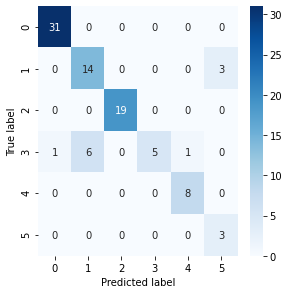


Model  2 :  	Loss:  0.2636 	Accuracy:  0.9451
Confusion Matrix:


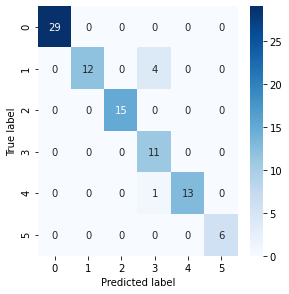


Model  3 :  	Loss:  0.4217 	Accuracy:  0.8462
Confusion Matrix:


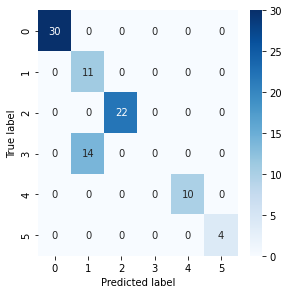


Model  4 :  	Loss:  0.4356 	Accuracy:  0.7802
Confusion Matrix:


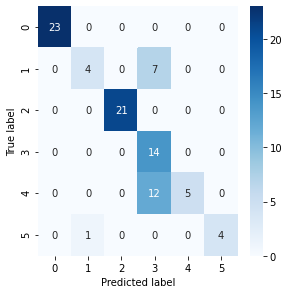



Model With the best Accuracy:  2
Model with the best loss:  2


In [207]:
print_results(1)

## Test 2 (Clinical Features): Results

Results:


Model  1 :  	Loss:  0.6276 	Accuracy:  0.8352
Confusion Matrix:


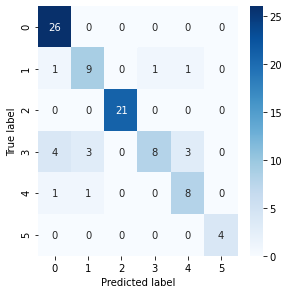


Model  2 :  	Loss:  0.7838 	Accuracy:  0.7033
Confusion Matrix:


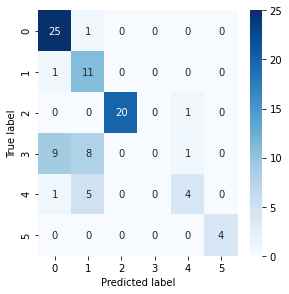


Model  3 :  	Loss:  1.0227 	Accuracy:  0.6264
Confusion Matrix:


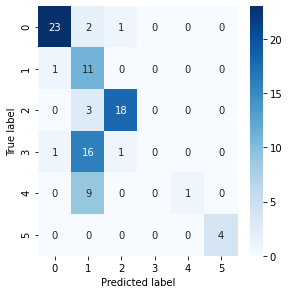


Model  4 :  	Loss:  1.2154 	Accuracy:  0.5165
Confusion Matrix:


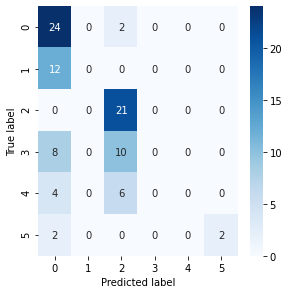



Model With the best Accuracy:  1
Model with the best loss:  1


In [208]:
print_results(2)

## Test 3 (Histopathological Features): Results

Results:


Model  1 :  	Loss:  0.3356 	Accuracy:  0.8571
Confusion Matrix:


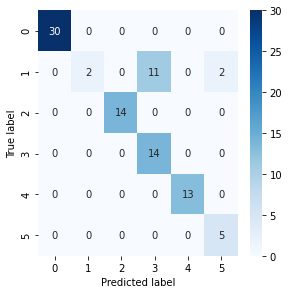


Model  2 :  	Loss:  0.3870 	Accuracy:  0.8462
Confusion Matrix:


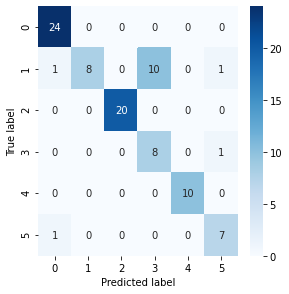


Model  3 :  	Loss:  0.4593 	Accuracy:  0.7802
Confusion Matrix:


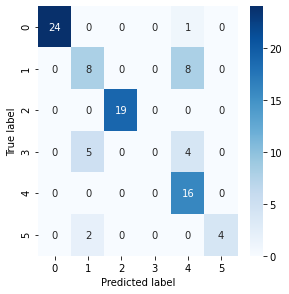


Model  4 :  	Loss:  0.6850 	Accuracy:  0.6374
Confusion Matrix:


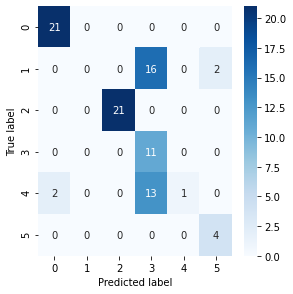



Model With the best Accuracy:  1
Model with the best loss:  1


In [209]:
print_results(3)

## Test 4 (Important Features): Results

Results:


Model  1 :  	Loss:  0.3158 	Accuracy:  0.9231
Confusion Matrix:


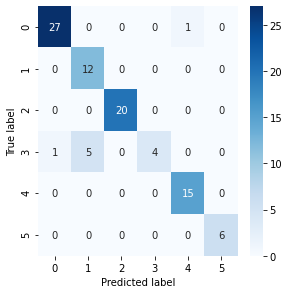


Model  2 :  	Loss:  0.3859 	Accuracy:  0.8462
Confusion Matrix:


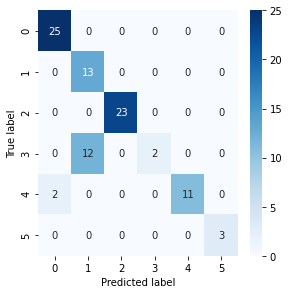


Model  3 :  	Loss:  0.4249 	Accuracy:  0.8352
Confusion Matrix:


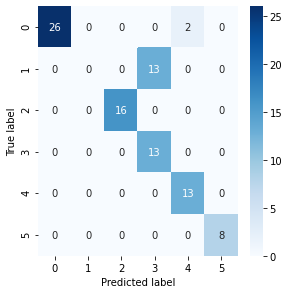


Model  4 :  	Loss:  0.7358 	Accuracy:  0.7582
Confusion Matrix:


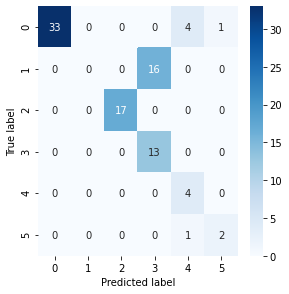



Model With the best Accuracy:  1
Model with the best loss:  1


In [210]:
print_results(4)

# Conclusiones


*   Los Modelos tienen más precisión cuando utilizan tanto los datos Clínicos e Histopatológicos.
*   La mejor arquitectura es la arquitectura diseñada para el modelo 1; una arquitectura no muy compleja como las otras y relativamente sencilla.



# Observaciones


*   La arquitectura 1 y la arquitectura 2 tienen desempeños muy similares, sin embargo, la arquitectura 1 tiene la precisión más alta en la mayoría de la pruebas, entonces concluímos que la arquitectura 1 es mejor para este problema.

